In [2]:
import warnings
import datetime
import numpy as np
import scipy as sp
import pandas as pd
import yfinance as yf
import ipywidgets as widgets
import matplotlib.pyplot as plt
from kit import interval_dict

warnings.filterwarnings('ignore')

The below code sources asset price data in local currency from Yahoo Finance, for a given period and frequency:

In [3]:
def get_yf_ts(ticker, period, interval):
    df = yf.Ticker(ticker).history(period=period, interval=interval)[['Close']].rename(columns={'Close' : ticker})
    df.index = df.index.to_period(interval_dict[interval])
    return df

period = '10y'
interval = '1mo'

msft = get_yf_ts('MSFT', period, interval)
aapl = get_yf_ts('AAPL', period, interval)

rf = get_yf_ts("^IRX", period, interval) / 100 # Expressed in % hence the division
df = msft.merge(aapl, left_index=True, right_index=True)
intervals = df.shape[0]

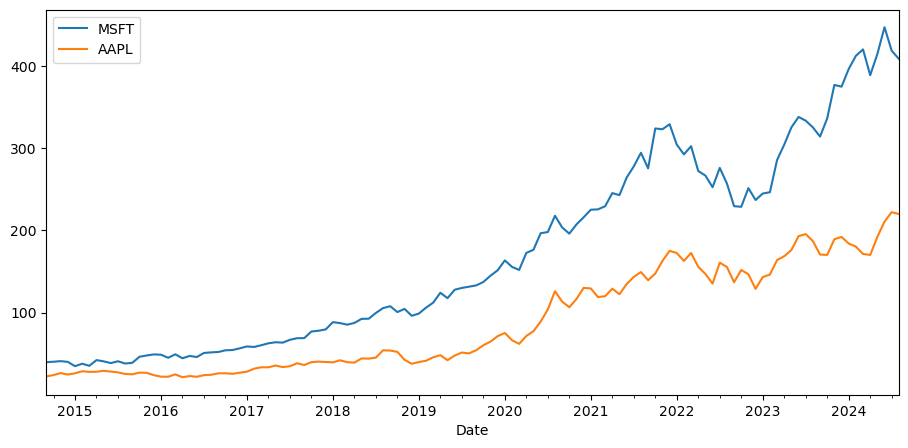

In [4]:
df.plot.line(figsize=(11,5))
plt.show() # Stock price

<b>Return</b> is a change of an asset price relative to its previous value $r_t=\frac{p_t - p_{t-1}}{p_{t-1}}$.

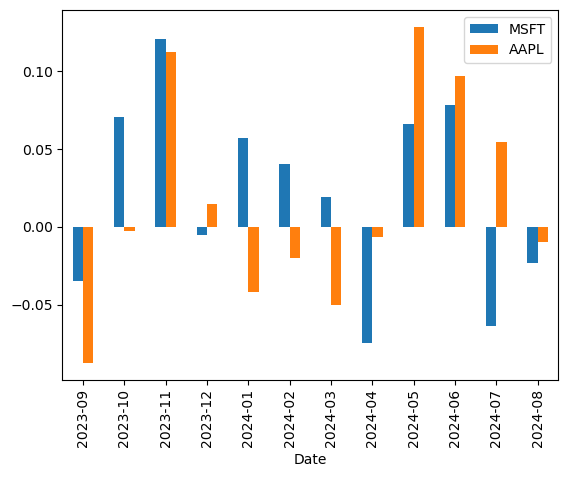

In [5]:
returns = df.pct_change().dropna()
returns[-12:].plot.bar() # Returns in the last year
plt.show()

<b>Compounded returns</b> allow for reinvesting any gains (or loss on an investment) between time periods and show a total level of return between the initial investment and end of the strategy. $r^c=\prod_{t=1}^T(1 + r_t)$

In [19]:
comp_return = np.exp(np.log1p(returns).sum()) # Total compounded return of both stocks in the last 10 years = (1 + returns).prod()
comp_return

MSFT    10.286797
AAPL     9.819543
dtype: float64

In [20]:
ret_mean, ret_vol = returns.mean(), returns.std()
ret_ann, ret_ann_vol = comp_return ** (12 / intervals) - 1, ret_vol * np.sqrt(12)
ret_mean, ret_vol, ret_ann, ret_ann_vol # Returns mean, volatility, annualized return and annualized v

(MSFT    0.021702
 AAPL    0.022552
 dtype: float64,
 MSFT    0.063009
 AAPL    0.080467
 dtype: float64,
 MSFT    0.262490
 AAPL    0.256635
 dtype: float64,
 MSFT    0.218271
 AAPL    0.278747
 dtype: float64)

In [10]:
ret_ann / ret_ann_vol

MSFT    1.312593
AAPL    0.926249
dtype: float64

<b>Excess return</b> is measured above any return that a risk-free rate will get.

In [11]:
rf_ann = ((1 + rf).prod()[0]**(1/intervals) - 1)
excess_ret = ret_ann - rf_ann  # Excess return annually
excess_ret

MSFT    0.268660
AAPL    0.243273
dtype: float64

<b>Sharpe ratio</b> shows return per unit volatility. *More details in the portfolio_opt.ipynb

In [12]:
sharpe = excess_ret / ret_ann_vol
sharpe

MSFT    1.242374
AAPL    0.871831
dtype: float64

<AxesSubplot:xlabel='Date'>

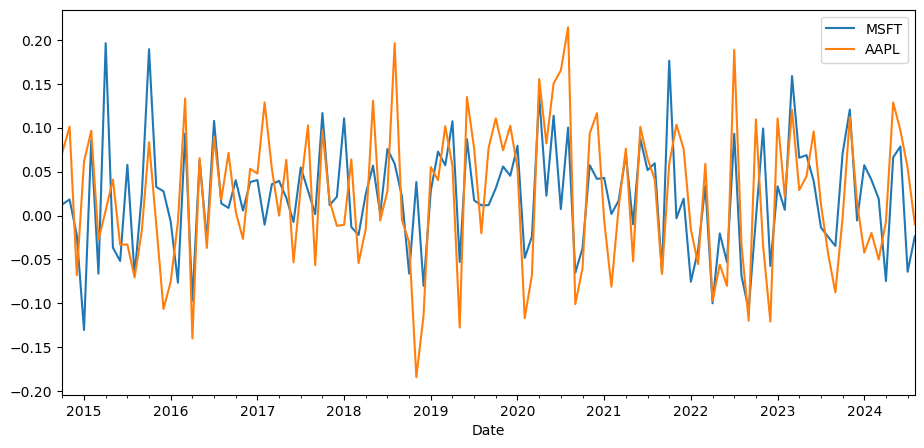

In [6]:
returns.plot(figsize=(11,5))

<b>Drawdown</b> refers to how much an asset is down from its previous peak before it recovers back to that level.

In [7]:
def drawdown(r):
    comp_return_ts = (1 + r).cumprod()
    comp_return_max = comp_return_ts.cummax()
    return (comp_return_ts - comp_return_max) / comp_return_max

s_drawdown = drawdown(returns)
s_drawdown.min(), s_drawdown.idxmin() # Maximum drawdown per stock and its date

(MSFT   -0.305285
 AAPL   -0.302177
 dtype: float64,
 MSFT    2022-10
 AAPL    2018-12
 dtype: period[M])

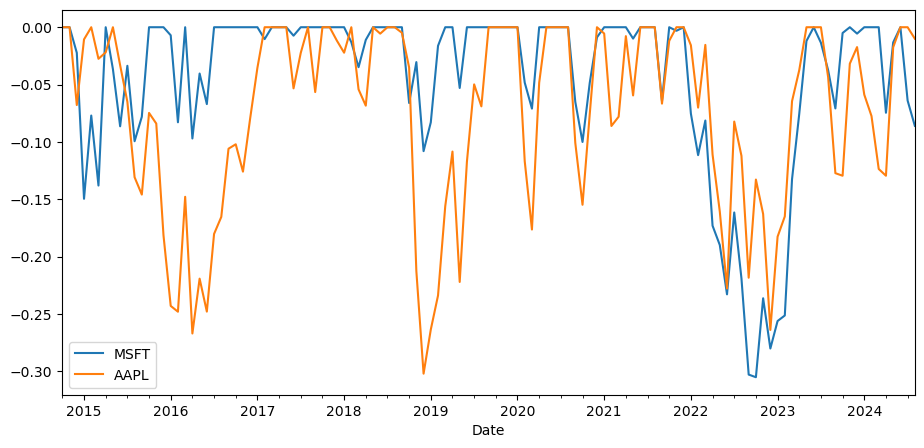

In [9]:
s_drawdown.plot(figsize=(11,5))
plt.show()

For the two assets in our population we observe the distribution of their returns for the last 10 years:

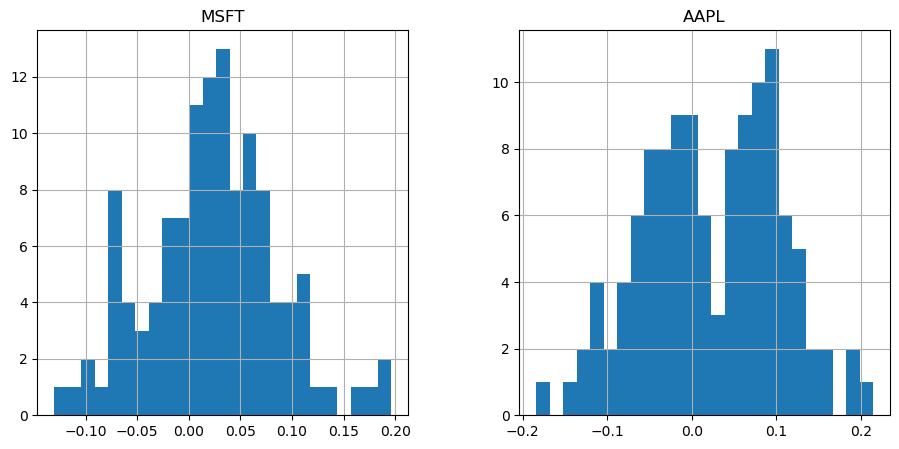

In [16]:
returns.hist(figsize=(11,5), bins=25)
plt.show()

<b>Skewness</b> of the return distribution measures its assymetry. Positively skewed distributions have the right tail longer than the left, while negatively skewed have the left tail longer than the right: $$\tilde{\mu}_3 = \frac{\sum_i^N(X_i - \bar{X})^3}{(N-1)\sigma^3}$$

In [17]:
"Skewness: MSFT {}, AAPL {}".format(*sp.stats.skew(returns))

'Skewness: MSFT 0.1384444191056546, AAPL -0.074221155997657'

<b>Kurtosis</b> of the distribution measures how fat its tails are, or how often outliers occur. A kurtosis of 3 is specific to the Gaussian distribution. $$\text{Kurt}[X] = \frac{E[ (X-\bar{X})^4 ]}{\sigma^4} $$

In [18]:
"Kurtosis: MSFT {}, AAPL {}".format(*sp.stats.kurtosis(returns)) #Note this is given in excess kurtosis i.e. 3+ the value

'Kurtosis: MSFT 0.19042442795537573, AAPL -0.5448344503356548'

The <b>Jarque–Bera test</b> is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a Gaussian distribution. A J=0 -> Gaussian;
$$J = \frac{n}{6} \left(\tilde{\mu}_3^2 + \frac{(\text{Kurt}[X]-3)^2}{4}  \right)$$

In [19]:
(len(returns) / 6) * (sp.stats.skew(returns) ** 2 + sp.stats.kurtosis(returns) ** 2 /4)

array([0.55993909, 1.58111184])

In [20]:
returns.aggregate(sp.stats.jarque_bera) # Jarque-Bera test and its p-value

,MSFT,AAPL
0,0.559939,1.581112
1,0.755807,0.453593


In [21]:
semideviation = lambda r: r[r<0].std() # Standard deviation only on the negative part of returns
semideviation(returns)

MSFT    0.032613
AAPL    0.042475
dtype: float64

Value at Risk <b>(VaR)</b> predicts the greatest possible losses over a specific time frame. It takes the n percentile tail of the distribution and assumes that should those returns occur for a given period of time what would be the largest possible loss.

In [22]:
returns.quantile(0.05) # Bottom 5th quantile of returns

MSFT   -0.075452
AAPL   -0.113935
Name: 0.05, dtype: float64

In [23]:
def var(r, q=0.05, cf=False): #cf for Cornish-Fisher modification otherwise quantile of Gaussian fit
    z = sp.stats.norm.ppf(q)
    if cf:
        mu_3, k = sp.stats.skew(r), sp.stats.kurtosis(r)
        z = (z +
                (z**2 - 1)*mu_3/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(mu_3**2)/36
            )

    return -(r.mean() + z*r.std(ddof=0))

In [24]:
var(returns, 0.05, False) # Bottom 5% Gaussian

MSFT    0.079142
AAPL    0.109254
dtype: float64

In [25]:
var(returns, 0.05, True) # Bottom 5% Cornish-Fisher

MSFT    0.080198
AAPL    0.116676
dtype: float64

<b>Log returns</b> is a common practice for representing returns. Besides being a mathematical convenience, it starts with the assumption that prices are log-normally distributed and is supported by the following reasons:
1. Prices cannot be negative, and a log-normal distribution matches this property
2. As shown in the compounding return

To be continued..

array([[<AxesSubplot:title={'center':'MSFT'}>,
        <AxesSubplot:title={'center':'AAPL'}>]], dtype=object)

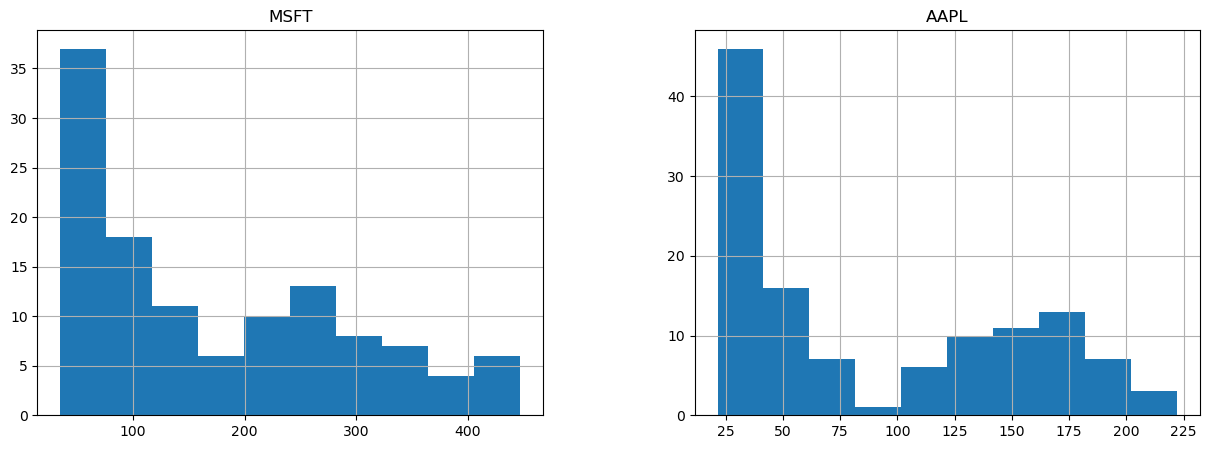

In [38]:
df.hist(bins=10, figsize=(15,5))